In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import dagshub
import mlflow

warnings.filterwarnings("ignore")

# Cargar datos
file_path_hogar = '../../../../data/processed/datos_consumo/hogar_individual_bcn/casa_bcn_clean.csv'
df = pd.read_csv(file_path_hogar)

c:\Users\anaig\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Preprocesamiento inicial
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')

# Variables temporales
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.weekday
df['hour'] = df['timestamp'].dt.hour
df['is_weekend'] = (df['weekday'] >= 5).astype(int)
df['is_holiday'] = df['timestamp'].dt.strftime('%Y-%m-%d').isin([
    "2017-01-06", "2017-04-14", "2017-04-17", "2017-05-01", "2017-06-05", "2017-06-24",
    "2017-08-15", "2017-09-11", "2017-09-25", "2017-10-12", "2017-11-01", "2017-12-06",
    "2017-12-08", "2017-12-25", "2017-12-26", "2018-01-01", "2018-01-06", "2018-03-30",
    "2018-04-02", "2018-05-01", "2018-08-15", "2018-09-11", "2018-10-12", "2018-11-01",
    "2018-12-06", "2018-12-08", "2018-12-25", "2018-12-26", "2019-01-01", "2019-04-19",
    "2019-04-22", "2019-05-01", "2019-06-10", "2019-06-24", "2019-08-15", "2019-09-11",
    "2019-09-24", "2019-10-12", "2019-11-01", "2019-12-06", "2019-12-25", "2019-12-26",
    "2020-01-01", "2020-01-06", "2020-04-10", "2020-04-13", "2020-05-01", "2020-06-01",
    "2020-06-24", "2020-08-15", "2020-09-11", "2020-09-24", "2020-10-12", "2020-12-08",
    "2020-12-25", "2020-12-26"
]).astype(int)

In [3]:
# Nuevas features
df["lag_1h"] = df["consumo_kwh"].shift(1)
df["lag_24h"] = df["consumo_kwh"].shift(24)
df["rolling_3h"] = df["consumo_kwh"].rolling(3).mean()
df["rolling_24h"] = df["consumo_kwh"].rolling(24).mean()
df["delta"] = df["consumo_kwh"].diff()

# Ciclicidad horaria
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

# Eliminar nulos generados por lag/rolling
df.dropna(inplace=True)

# Umbral mínimo
umbral_min = df[df['consumo_kwh'] > 0]['consumo_kwh'].min()

In [4]:
# Variables de entrada
features = [
    'hour', 'weekday', 'is_weekend', 'is_holiday',
    'tmed', 'tmin', 'tmax', 'prec', 'velmedia', 'racha', 'sol', 'hrMedia', 'año',
    'lag_1h', 'lag_24h', 'rolling_3h', 'rolling_24h', 'delta',
    'hour_sin', 'hour_cos'
]
target = 'consumo_kwh'

In [5]:
# Separar por fecha
train = df[df['timestamp'] < '2020-01-01']
test = df[df['timestamp'] >= '2020-01-01']

X_test = test[features]
y_test = test[target]

In [6]:
# Función Optuna con validación temporal
def objective(trial):
    params = {
        'objective': 'reg:absoluteerror',  # MAE directo
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # División temporal para validación
    split_point = train['timestamp'].quantile(0.8)
    sub_train = train[train['timestamp'] < split_point]
    val = train[train['timestamp'] >= split_point]

    X_sub_train = sub_train[features]
    y_sub_train = sub_train[target]
    X_val = val[features]
    y_val = val[target]

    model = xgb.XGBRegressor(**params)
    model.fit(X_sub_train, y_sub_train)
    y_pred = model.predict(X_val)
    y_pred = np.clip(y_pred, umbral_min, None)

    return mean_absolute_error(y_val, y_pred)

In [7]:
# Optuna tuning
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Entrenar final con todo el training
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(train[features], train[target])

[I 2025-04-02 20:13:34,185] A new study created in memory with name: no-name-d5ea2b27-ef99-4297-b060-1f8b69f86e22
[I 2025-04-02 20:13:37,060] Trial 0 finished with value: 0.015035540741408865 and parameters: {'n_estimators': 353, 'max_depth': 3, 'learning_rate': 0.12039584287315935, 'subsample': 0.6812257010299683, 'colsample_bytree': 0.8152129785087259, 'gamma': 3.2534248513673742, 'reg_alpha': 0.6812064880144469, 'reg_lambda': 0.14142057539629393, 'min_child_weight': 7}. Best is trial 0 with value: 0.015035540741408865.
[I 2025-04-02 20:13:43,087] Trial 1 finished with value: 0.014417184212861787 and parameters: {'n_estimators': 693, 'max_depth': 3, 'learning_rate': 0.19680328063574745, 'subsample': 0.6252152524079186, 'colsample_bytree': 0.567839431295479, 'gamma': 8.383191660181534, 'reg_alpha': 0.9179914567092672, 'reg_lambda': 0.5255490657974976, 'min_child_weight': 10}. Best is trial 1 with value: 0.014417184212861787.
[I 2025-04-02 20:13:47,948] Trial 2 finished with value: 0.0

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.979704711376817, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=3.437386056971851,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06450757988419968,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=704, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [8]:

# Validación secuencial
rmse_values, mae_values = [], []
errores_previos, predicciones_totales = [], pd.DataFrame()
for dia in pd.date_range(start='2020-01-01', end=df['timestamp'].max(), freq='D'):
    test_dia = df[df['timestamp'].dt.date == dia.date()]
    if test_dia.empty:
        continue

    X_test_dia = test_dia[features]
    y_real_dia = test_dia[target]
    y_pred_dia = best_model.predict(X_test_dia)
    y_pred_dia = np.clip(y_pred_dia, umbral_min, None)

    # Ajuste con error histórico
    ajuste_error = np.mean(errores_previos[-10:]) if len(errores_previos) > 10 else 0
    y_pred_ajustado = np.clip(y_pred_dia + ajuste_error, umbral_min, None)

    rmse = np.sqrt(mean_squared_error(y_real_dia, y_pred_ajustado))
    mae = mean_absolute_error(y_real_dia, y_pred_ajustado)
    rmse_values.append(rmse)
    mae_values.append(mae)
    errores_previos.extend((y_real_dia - y_pred_dia).values)

    df_pred = pd.DataFrame({
        'timestamp': test_dia['timestamp'].values,
        'real': y_real_dia.values,
        'predicho': y_pred_dia,
        'predicho_ajustado': y_pred_ajustado
    })
    predicciones_totales = pd.concat([predicciones_totales, df_pred])

In [9]:
# Métricas globales
rmse_final = np.mean(rmse_values)
mae_final = np.mean(mae_values)
print(f"RMSE Final: {rmse_final:.2f}")
print(f"MAE Final: {mae_final:.2f}")

RMSE Final: 0.08
MAE Final: 0.06


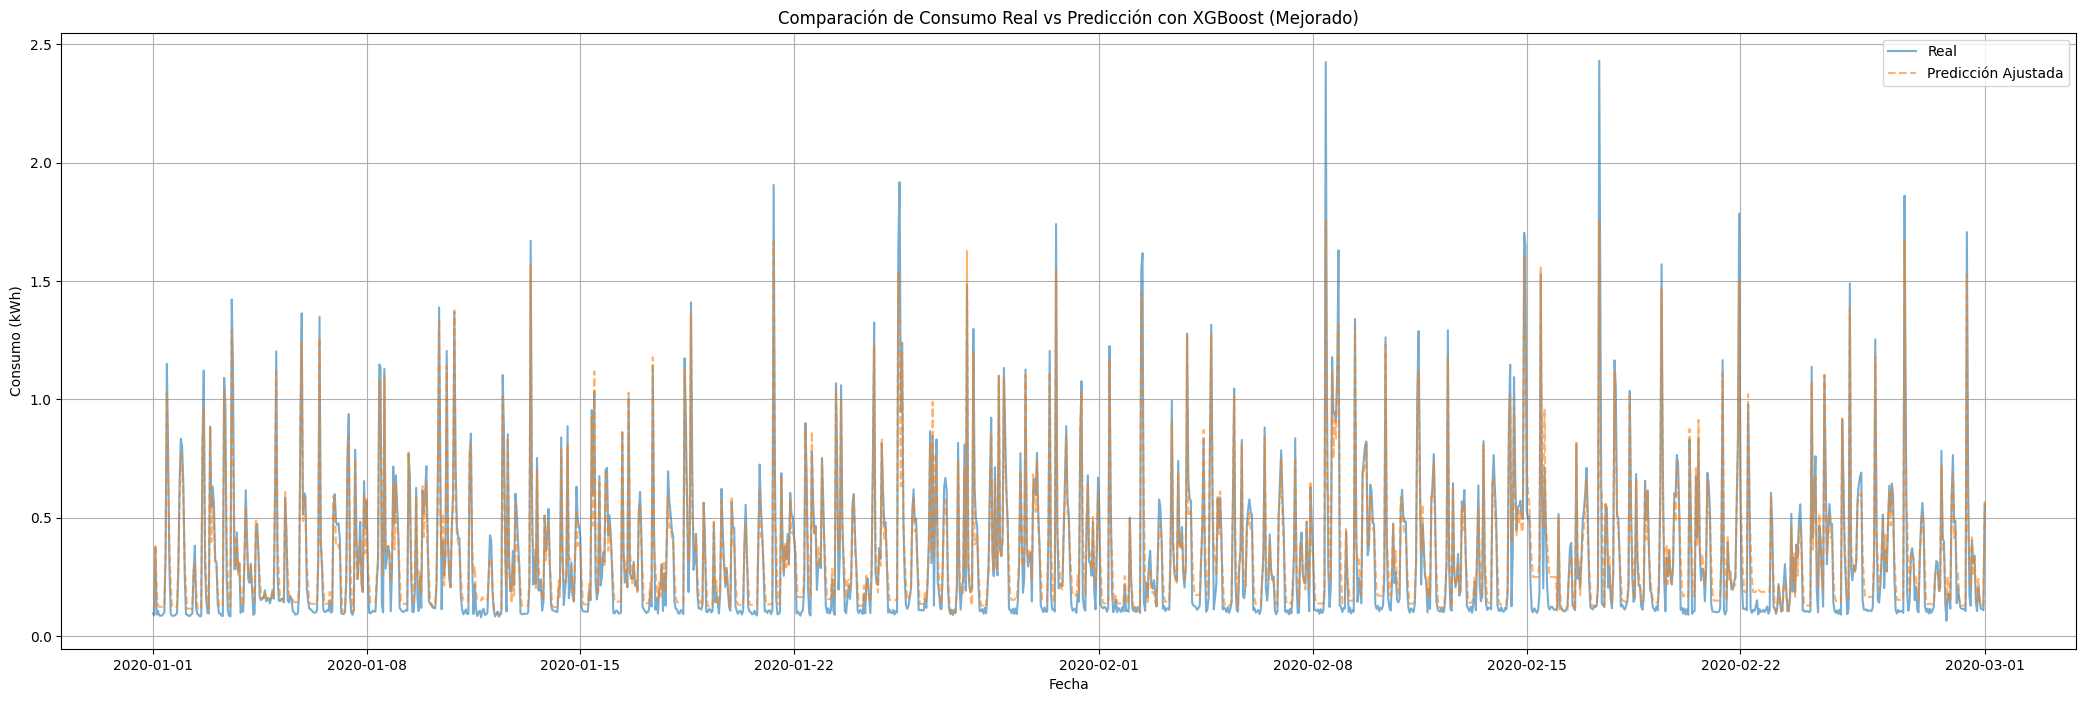

In [10]:
# Gráfico
plt.figure(figsize=(26, 8))
plt.plot(predicciones_totales['timestamp'], predicciones_totales['real'], label="Real", alpha=0.6)
plt.plot(predicciones_totales['timestamp'], predicciones_totales['predicho_ajustado'], label="Predicción Ajustada", linestyle="dashed", alpha=0.6)
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.title("Comparación de Consumo Real vs Predicción con XGBoost (Mejorado)")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Log en MLflow
dagshub.init(repo_owner='auditoria.SGBA1', repo_name='Proyectos-SGBA1', mlflow=True)
with mlflow.start_run(run_name="xgboost_consumo_mejorado") as run:
    run_id = run.info.run_id
    model_name = "XGBoost-Consumo-Hogar"
    model_uri = f"runs:/{run_id}/xgboost_model"

    for param, value in best_params.items():
        mlflow.log_param(param, value)
    mlflow.log_metric("RMSE", rmse_final)
    mlflow.log_metric("MAE", mae_final)

    plot_path = "consumo_vs_prediccion_xgboost_mejorado.png"
    plt.figure(figsize=(26, 8))
    plt.plot(predicciones_totales['timestamp'], predicciones_totales['real'], label="Real", alpha=0.6)
    plt.plot(predicciones_totales['timestamp'], predicciones_totales['predicho_ajustado'], label="Predicción Ajustada", linestyle="dashed")
    plt.xlabel("Fecha")
    plt.ylabel("Consumo (kWh)")
    plt.title("Comparación de Consumo Real vs Predicción con XGBoost (Mejorado)")
    plt.legend()
    plt.grid(True)
    plt.savefig(plot_path)
    plt.close()

    mlflow.log_artifact(plot_path)
    mlflow.xgboost.log_model(best_model, artifact_path="xgboost_model")
    mlflow.register_model(model_uri=model_uri, name=model_name)

print(f"Modelo registrado en MLflow con run_id: {run_id}")

Accessing as anaigs

Initialized MLflow to track repo "auditoria.SGBA1/Proyectos-SGBA1"

Repository auditoria.SGBA1/Proyectos-SGBA1 initialized!

2025/04/02 20:25:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'XGBoost-Consumo-Hogar' already exists. Creating a new version of this model...
2025/04/02 20:25:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost-Consumo-Hogar, version 5
Created version '5' of model 'XGBoost-Consumo-Hogar'.


🏃 View run xgboost_consumo_mejorado at: https://dagshub.com/auditoria.SGBA1/Proyectos-SGBA1.mlflow/#/experiments/0/runs/4c4ba23c7c834c0e8b14de32f70ce62c
🧪 View experiment at: https://dagshub.com/auditoria.SGBA1/Proyectos-SGBA1.mlflow/#/experiments/0
Modelo registrado en MLflow con run_id: 4c4ba23c7c834c0e8b14de32f70ce62c


Initialized MLflow to track repo "auditoria.SGBA1/Proyectos-SGBA1"

Repository auditoria.SGBA1/Proyectos-SGBA1 initialized!


MAE (Error Medio Absoluto) para 2020-01-01: 0.0531 kWh

Predicciones vs Real:
                timestamp  consumo_kwh      yhat
18023 2020-01-01 00:00:00        0.096  0.123883
18024 2020-01-01 01:00:00        0.087  0.123883
18025 2020-01-01 02:00:00        0.375  0.385761
18026 2020-01-01 03:00:00        0.091  0.182468
18027 2020-01-01 04:00:00        0.107  0.131455
18028 2020-01-01 05:00:00        0.087  0.123883
18029 2020-01-01 06:00:00        0.087  0.123883
18030 2020-01-01 07:00:00        0.086  0.123883
18031 2020-01-01 08:00:00        0.093  0.123883
18032 2020-01-01 09:00:00        0.098  0.123883
18033 2020-01-01 10:00:00        0.349  0.360316
18034 2020-01-01 11:00:00        1.150  1.029536
18035 2020-01-01 12:00:00        0.776  0.636627
18036 2020-01-01 13:00:00        0.294  0.377833
18037 2020-01-01 14:00:00        0.095  0.230027
18038 2020-01-01 15:00:00        0.086  0.123883
18039 2020-01-01 16:00:00        0.086  0.123883
18040 2020-01-01 17:00:00        0.086 

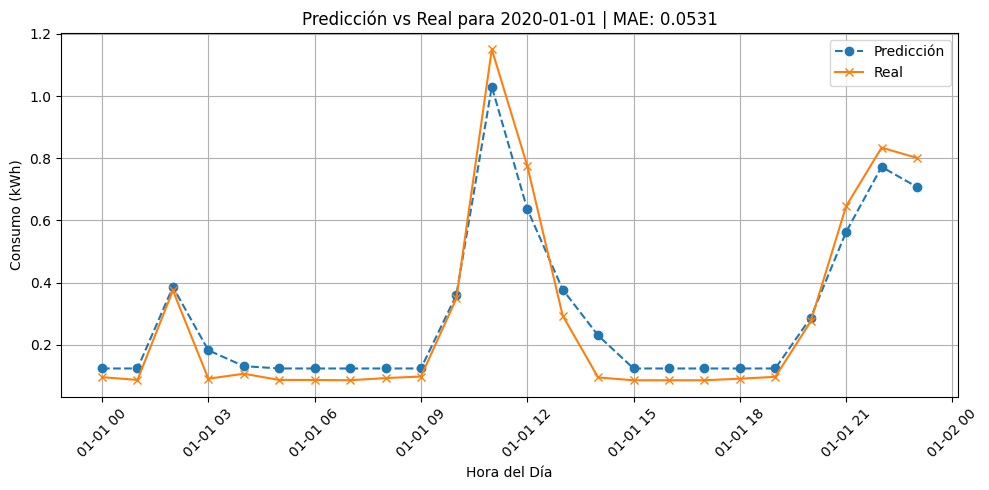

In [16]:
import os
import mlflow.pyfunc
import pandas as pd
import matplotlib.pyplot as plt
import dagshub
import numpy as np
from sklearn.metrics import mean_absolute_error

# Inicializar DAGsHub
dagshub.init(repo_owner="auditoria.SGBA1", repo_name="Proyectos-SGBA1", mlflow=True)

# Columnas utilizadas en el modelo completo (entrenado con clima + lags + rolling + ciclos)
columnas_modelo_completo = [
    "hour", "weekday", "is_weekend", "is_holiday",
    "tmed", "tmin", "tmax", "prec", "velmedia", "racha", "sol", "hrMedia", "año",
    "lag_1h", "lag_24h", "rolling_3h", "rolling_24h", "delta",
    "hour_sin", "hour_cos"
]

# Lista de festivos
FESTIVOS = [
    "2017-01-06","2017-04-14","2017-04-17","2017-05-01","2017-06-05","2017-06-24",
    "2017-08-15","2017-09-11","2017-09-25","2017-10-12","2017-11-01","2017-12-06",
    "2017-12-08","2017-12-25","2017-12-26","2018-01-01","2018-01-06","2018-03-30",
    "2018-04-02","2018-05-01","2018-08-15","2018-09-11","2018-10-12","2018-11-01",
    "2018-12-06","2018-12-08","2018-12-25","2018-12-26","2019-01-01","2019-04-19",
    "2019-04-22","2019-05-01","2019-06-10","2019-06-24","2019-08-15","2019-09-11",
    "2019-09-24","2019-10-12","2019-11-01","2019-12-06","2019-12-25","2019-12-26",
    "2020-01-01","2020-01-06","2020-04-10","2020-04-13","2020-05-01","2020-06-01",
    "2020-06-24","2020-08-15","2020-09-11","2020-09-24","2020-10-12","2020-12-08",
    "2020-12-25","2020-12-26"
]

# Ruta al dataset con clima y consumo
file_path_hogar = '../../../../data/processed/datos_consumo/hogar_individual_bcn/casa_bcn_clean.csv'

# Intentar cargar el dataset
try:
    df_clima = pd.read_csv(file_path_hogar, parse_dates=["timestamp"])
    dataset_cargado = True
except Exception as e:
    print("No se ha encontrado el clima. No se puede predecir.")
    df_clima = None
    dataset_cargado = False

def predecir_dia(fecha):
    if not dataset_cargado:
        print("No se ha encontrado el clima. No se puede predecir.")
        return

    fecha_dt = pd.to_datetime(fecha)

    # Usar desde 2 días antes para calcular bien rolling y lags
    fecha_inicio = fecha_dt - pd.Timedelta(hours=48)
    fecha_fin = fecha_dt + pd.Timedelta(hours=23)

    df_pred = df_clima[(df_clima["timestamp"] >= fecha_inicio) & (df_clima["timestamp"] <= fecha_fin)].copy()

    if df_pred.empty:
        print("No se han encontrado datos de clima suficientes para este rango. No se puede predecir.")
        return

    # Features temporales
    df_pred["hour"] = df_pred["timestamp"].dt.hour
    df_pred["weekday"] = df_pred["timestamp"].dt.weekday
    df_pred["is_weekend"] = (df_pred["weekday"] >= 5).astype(int)
    df_pred["is_holiday"] = df_pred["timestamp"].dt.strftime("%Y-%m-%d").isin(FESTIVOS).astype(int)

    # Variables adicionales del modelo
    df_pred["lag_1h"] = df_pred["consumo_kwh"].shift(1)
    df_pred["lag_24h"] = df_pred["consumo_kwh"].shift(24)
    df_pred["rolling_3h"] = df_pred["consumo_kwh"].rolling(3).mean()
    df_pred["rolling_24h"] = df_pred["consumo_kwh"].rolling(24).mean()
    df_pred["delta"] = df_pred["consumo_kwh"].diff()
    df_pred["hour_sin"] = np.sin(2 * np.pi * df_pred["hour"] / 24)
    df_pred["hour_cos"] = np.cos(2 * np.pi * df_pred["hour"] / 24)

    # Eliminar NaNs generados por lags/rolling
    df_pred = df_pred.dropna()

    # Filtrar solo el día que se quiere predecir
    df_pred = df_pred[df_pred["timestamp"].dt.date == fecha_dt.date()]

    if df_pred.empty:
        print(f"No hay suficientes datos para predecir correctamente el día {fecha}.")
        return

    # Separar consumo real si existe
    y_real = df_pred["consumo_kwh"] if "consumo_kwh" in df_pred.columns else None

    # Cargar modelo
    model = mlflow.pyfunc.load_model("models:/XGBoost-Consumo-Hogar/latest")
    X_pred = df_pred[columnas_modelo_completo]
    df_pred["yhat"] = model.predict(X_pred)

    # Visualización y métricas
    if y_real is not None:
        mae = mean_absolute_error(y_real, df_pred["yhat"])
        print(f"\nMAE (Error Medio Absoluto) para {fecha}: {mae:.4f} kWh")
        print("\nPredicciones vs Real:")
        print(df_pred[["timestamp", "consumo_kwh", "yhat"]])

        plt.figure(figsize=(10, 5))
        plt.plot(df_pred["timestamp"], df_pred["yhat"], marker='o', linestyle='--', label="Predicción")
        plt.plot(df_pred["timestamp"], y_real, marker='x', linestyle='-', label="Real")
        plt.xlabel("Hora del Día")
        plt.ylabel("Consumo (kWh)")
        plt.title(f"Predicción vs Real para {fecha} | MAE: {mae:.4f}")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 5))
        plt.plot(df_pred["timestamp"], df_pred["yhat"], marker='o', linestyle='dashed', label="Predicción")
        plt.xlabel("Hora del Día")
        plt.ylabel("Consumo (kWh)")
        plt.title(f"Predicción de Consumo para {fecha}")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Ejemplo de uso
predecir_dia("2020-01-01")